# Dipolar spin-down with magnetic field decay

In [1]:
#!/usr/bin/env python3
"""dipolar_spindown_Bdecay.ipynb: a notebook to recreate results of Ronchi et al. (2022)"""

__author__ = "Michele Ronchi"
__copyright__ = "Copyright 2022"
__credits__ = ["Michele Ronchi"]
__license__ = "MIT"
__maintainer__ = "Michele Ronchi"
__email__ = "ronchi@ice.csic.es"

This notebook contains the code to study the spin-period evolution of pulsars spinning down due to dipolar losses alone in the presence of magnetic field decay. If one consider field decay, long spin periods ($10 \, {\rm s}$) can be reached only in the case of strong magnetic fields ($\gtrsim 10^{15} \, {\rm G}$) (see [Ronchi et al. 2022](https://arxiv.org/abs/2201.11704)). 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from scipy.integrate import odeint
from scipy.optimize import curve_fit
from typing import Tuple

import constants as const
import plot_settings

In [3]:
# Characteristic neutron star radius in [cm].
NS_radius = 1.1e6

# Characteristic neutron star mass in solar masses.
NS_mass = 1.4 * const.M_SUN

# Dimensionless coefficients k_0, k_1, k_2 for a force-free magnetosphere
# taken from Spitkovsky (2006) and Philippov et al. (2014).
# For comparison, in vacuum k_0 = 0 and k_1 = k_2 = 2/3.
k_coefficients = [1.0, 1.0, 1.0]

# Canonical neutron star moment of inertia in [g cm^2] assuming a perfect solid sphere.
NS_inertia = 2.0 / 5.0 * NS_mass * NS_radius ** 2

# Auxiliary quantity beta as defined in eq. (72) of Pons & Vigano (2019).
beta = 1./4. * NS_radius ** 6 / (NS_inertia * const.C ** 3)

# Assume an inclination angle in [rad].
chi = 0.

# Incorporate the inclination angle dependence into a constant.
beta_1 = beta * (k_coefficients[0] + k_coefficients[1] * np.sin(chi) ** 2)

# Dominant conductivity based on phonon or impurity scattering, in [1/s].
# For details see Cumming et al. (2004) or Gourgouliatos and Cumming (2014).
sigma = 1e24

# Characteristic length scale of the magnetic field in [cm].
L = 1e5

# Characteristic electron density in [g/cm^3].
n_e = 1e35

# Maximum time reached by the evolution in [yr].
t_max = 1.e8

# Initial spin period of the neutron star in [s].
P_in = 0.01

# Range of initial magnetic fields in [G].
B0_min = 10**(11.5)  # [G]
B0_max = 10**(17.5)  # [G]

In [4]:
def timescale_Ohm(L: float, sigma: float) -> float:
    """
    Calculating the ohmic diffusion timescale for a given conductivity and characteristic magnetic
    field length scale. Note that for our purposes, we neglect the fact that both quantities can
    vary significantly with depth inside the neutron star, and we simply use effective quantities
    that reflect the ohmic diffusion process.

    Args:
        L (float): characteristic length scale on which the magnetic field varies, measured in [cm].
        sigma (float): conductivity of the dominating dissipative process, measure in [1/s].

    Returns:
        (float): ohmic diffusion timescale in [yr].
    """

    tau_Ohm = 4 * np.pi * sigma * L ** 2 / (const.C ** 2)
    
    return tau_Ohm


def timescale_Hall(B: float, L: float, n_e: float) -> float:
    """
    Calculating the Hall timescale for a given field strength, characteristic magnetic field length
    scale and electron density. Note that for our purposes, we neglect the fact that all quantities can
    vary significantly with depth inside the neutron star, and we simply use effective quantities
    that reflect the conservative Hall process.
    B will be identified with the initial dipolar magnetic field components at the pulsars' pole.

    Args:
        B (float): (local) magnetic field strength, measured in [G].
        L (float): characteristic length scale on which the magnetic field varies, measured in [cm].
        n_e (float): electron density, measured in [g/cm^3].

    Returns:
        (float): Hall timescale in [yr].
    """

    tau_Hall = (
        4 * np.pi * const.E * n_e * L ** 2 / (const.C * B)
    )

    return tau_Hall


def field_derivative(B: float, B_initial: float) -> float:
    """
    Calculating the change in the magnetic field strength of a pulsar based on a simplified
    differential equation (see eq. (18) of Aguilera et al. (2008)) that captures the
    characteristics of more complicated numerical simulations of pulsar magnetic field
    evolution, i.e., at early timescales the Hall evolution dominates, while at late times
    the exponential magnetic field decay due to Ohmic dissipation kicks in. Note that as
    explained in Aguilera et al. (2008) the Hall timescale corresponds to that of the initial
    field strength.

    Args:
        B (float): pulsar's magnetic field magnitudes evolving with time, measured in [G].
        B_initial (float): pulsar's initial magnetic field magnitudes, measured in [G].

    Returns:
        (float): magnetic field derivatives for a simulated pulsars in [G/yr].
    """

    tau_Ohm = timescale_Ohm(L, sigma)
    tau_Hall = timescale_Hall(B_initial, L, n_e)

    B_deriv = - B / tau_Ohm - B ** 2 / (tau_Hall * B_initial)
    
    return B_deriv

In [5]:
def omega_derivative(omega:float, B:float) -> float:
    """
    Derivative of the spin frequency.
    
    Args:
        omega(float): value of the spin frequency measured omega in [1/s].
        B(float): current value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G].   

    Returns:
        (float): Derivative of the spin frequency [s^-2].
    """    
    
    omegadot = - beta_1 * B**2 * omega ** 3
            
    return omegadot

In [6]:
def diff_equations_system(t:float, initial_cond:np.ndarray, B0:float) -> float:
    """
    Derivative of the spin frequency for the three phases, direct accretion, propeller and ejector.
    See Ho et al. (2016).

    Args:
        t(float): time variable in [s],
        initial_cond(np.ndarray): current value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G] and value of the spin frequency measured omega in [1/s].
        B0 (float): initial value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G].

    Returns:
        (float): Derivative of the spin frequency for the three phases, direct accretion, propeller and ejector [s^-2].
    """    
    B = initial_cond[0]
    omega = initial_cond[1]
    
    Bdot = field_derivative(B, B0)
    omegadot = omega_derivative(omega, B)
        
    derivatives = np.array([Bdot, omegadot])
    
    return derivatives

In [7]:
def em_rotational_evolution_odeint(
    B0: float,
    P0: float,
    t_max: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Evolving the neutron stars' spin period.

    Args:
        B0 (float): initial value of the magnetic field magnitude, measured in [G].
        P0 (float): pulsars' initial spin period, measured in [s].
        t_max (float): maximum time for the evolution in [yr].

    Returns:
        (np.ndarray, np.ndarray): time array in [yr], spin period as a function of time in [s], 
        magnetic field as a function of time in [s]
    """

    # Define the time grid in s.
    t_max = t_max * const.YR_TO_S
    time_grid = np.logspace(np.log10(10.), np.log10(t_max), 2000) 

    # set the initial conditions
    omega0 = 2.*np.pi / P0
    
    initial_conditions = np.array([B0, omega0])
    
    evol_output = np.array(
            odeint(
                diff_equations_system,
                y0=initial_conditions,
                t=time_grid,
                args=(B0,),
                tfirst=True,
            )
        )

    B_t = np.array(evol_output[:, 0].tolist())
    omega_t = np.array(evol_output[:, 1].tolist())
    
    P_t = 2*np.pi / omega_t
    
    return time_grid / const.YR_TO_S, P_t, B_t

In [8]:
def P_vs_time_Bconst(t: np.ndarray, P0: float, B0: float) -> float:
    """
    Spin period evolution as a function of time for dipolar losses only by assuming that the 
    magnetic field is constant in time. we assume that the inclination angle chi.

    Args:
        t (np.ndarray): time in [yr].
        P0 (float): value of the initial spin period measured in [s].
        B0 (np.ndarray): value of the initial dipolar component of the magnetic field at the
        magnetic pole measured in [G].
    
    Returns:
        (np.ndarray): spin period as a function of time in [s].
    """  
    
    t = t * const.YR_TO_S

    omega0 = 2.*np.pi / P0
    
    t_em = 1./(2 * beta_1 * B0**2 *omega0**2)
        
    omega_t = omega0 * (1. + t/t_em)**(-1./2.)
    
    P_t = 2*np.pi / omega_t
    
    return P_t

Plot the pulsar spin-period evolution in time for dipolar spin-down for different values of the initial magnetic field $B_0$. The dashed lines represent the evolution curves for a constant magnetic field, while the solid lines represent the evolution tracks for a decaying magnetic field. In the background, the gray points represent the ob-
served radio pulsars (Data from the ATNF Pulsar Catalog, https://www.atnf.csiro.au/research/pulsar/psrcat/; [Manchester et al. 2005](https://ui.adsabs.harvard.edu/abs/2005AJ....129.1993M/abstract)) and red triangles represent the currently detected magnetars (Data from the Magnetar Outburst Online
Catalogue, http://magnetars.ice.csic.es/; [Coti Zelati et al.
2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.474..961C/abstract)) highlighting those that exhibit radio emission (orange circles). We consider the characteristic age $\tau_{\rm c} = P/(2 \dot{P})$ as a
proxy for their real age.

In [9]:
# Read data from the ATNF Pulsar Catalog.
df_atnf = pd.read_csv(
    "../../data/observed/atnf_catalog_08-02-2022/atnf_catalog_full.csv",
    delimiter=";",
    header=[0, 1],
)
df_atnf.head()

,#,PSRJ,PMRA,PMDEC,PX,POSEPOCH,Gl,Gb,RAJD,DECJD,...,W50,W10,S400,S1400,S2000,DIST,DIST_DM,ASSOC,SURVEY,PSR
,Unnamed: 0_level_1,Unnamed: 1_level_1,[mas/yr],[mas/yr],[mas],[MJD],[deg],[deg],[deg],[deg],...,[ms],[ms],[mJy],[mJy],[mJy],[kpc],[kpc],Unnamed: 20_level_1,Unnamed: 21_level_1,TYPE
0,1,J0002+6216,NAN,NAN,NAN,55806,117.327,-0.074,0.742375,62.269278,...,NAN,NAN,NAN,0.02,NAN,6.357,6.357,"GRS:4FGL_J0002.8+6217[fermi21],XRS:1XSPS",FermiBlind,HE[wcp+18]
1,2,J0006+1834,NAN,NAN,NAN,49079.5,108.172,-42.985,1.520000,18.583056,...,82,195,0.2,NAN,NAN,0.86,0.86,NAN,ar4,NAN
2,3,J0007+7303,NAN,NAN,NAN,54952,119.660,10.463,1.757083,73.052056,...,NAN,NAN,NAN,NAN,NAN,1.4,NAN,"GRS:4FGL_J0007.0+7303[fermi21],XRS:RX_J0",FermiBlind,NRAD
3,4,J0011+08,NAN,NAN,NAN,57022,106.228,-53.407,2.891667,8.166667,...,28,NAN,NAN,NAN,NAN,5.399,5.399,NAN,AO327,NAN
4,5,J0014+4746,19.3,-19.7,NAN,49664,116.497,-14.631,3.573958,47.775944,...,88.7,142.5,14,3,NAN,1.776,1.776,NAN,"gb1,gb2,gb3,lotaas",NAN


In [10]:
# Select only isolated radio pulsars.
df_atnf = df_atnf[~df_atnf["P0"]["[s]"].isin(['NAN'])]
df_atnf = df_atnf[~df_atnf["P1"]["[s/s]"].isin(['NAN'])]
df_atnf_radio = df_atnf[df_atnf['PSR']['TYPE'].isin(['NAN'])]

P = df_atnf_radio["P0"]["[s]"].to_numpy().astype(np.float) 
Pdot = df_atnf_radio["P1"]["[s/s]"].to_numpy().astype(np.float) 

P = P[Pdot>1.e-18]
Pdot = Pdot[Pdot>1.e-18]
tau_c = P/(2*Pdot)
tau_c = tau_c / const.YR_TO_S

In [11]:
# Read data from the Magnetar Outburst Online Catalog.
df_magnetar = pd.read_csv(
    "../../data/observed/magnetars.csv",
    delimiter=";",
    header=[0],
)
df_magnetar.head()

,source,radio,association,class,distance(kpc),l(deg),b(deg),period(s),pdot(1e-11s/s)
0,SGR1627-41,False,SNR G337.0-0.1,Magnetar,11,336.98,-0.11,2.59,1.900
1,1E2259+586,False,SNR CTB109,Magnetar,3.2,109.09,-1.00,6.98,0.048
2,XTEJ1810-197,True,NAN,Magnetar,3.5,10.73,-0.16,5.54,0.283
3,SGR1806-20,False,W31 open cluster,Magnetar,8.7,10.00,-0.24,7.75,7.500
4,CXOUJ1647-4552,False,Westerlund1,Magnetar,4,339.55,-0.43,10.61,0.097


In [12]:
P_mag = df_magnetar["period(s)"].to_numpy().astype(np.float) 
Pdot_mag = df_magnetar["pdot(1e-11s/s)"].to_numpy().astype(np.float) * 10**(-11)
radio = df_magnetar["radio"].to_numpy().astype(np.bool)

tau_c_mag = P_mag/(2*Pdot_mag)
tau_c_mag = tau_c_mag / const.YR_TO_S

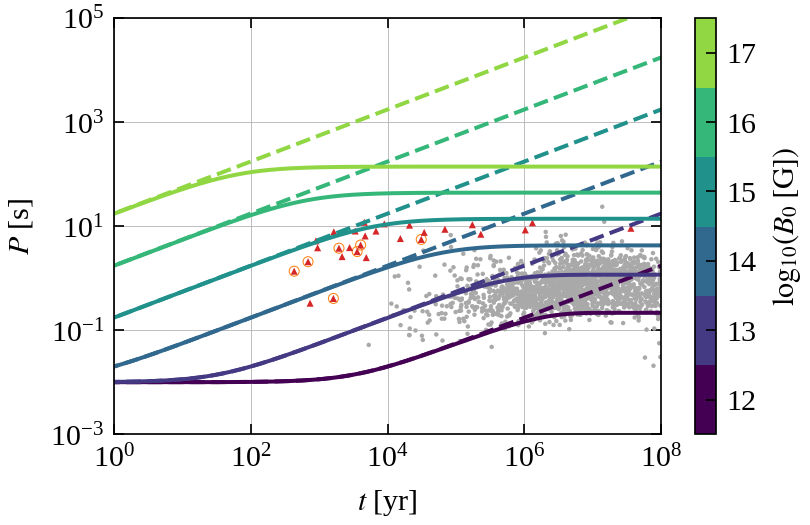

In [13]:
# Plot the data together with the model evolution curves.
log_B0_edges = np.linspace(np.log10(B0_min), np.log10(B0_max), 7)
log_B0_centers = 0.5 * (log_B0_edges[1:] + log_B0_edges[:-1])
B0_edges = 10**log_B0_edges
B0_centers = 10**log_B0_centers

colors = plt.get_cmap("viridis", len(B0_centers)+1)

norm = mpl.colors.BoundaryNorm(log_B0_edges, len(B0_centers))
sm = plt.cm.ScalarMappable(norm=norm, cmap=colors)
sm.set_array([])

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xscale('log') 
ax.set_yscale('log')
ax.set_xlabel(r'$t$ [yr]')
ax.set_ylabel(r'$P$ [s]')

ax.set_xlim(1.,t_max)
ax.set_ylim(1.e-3,1.e5)

ax.scatter(
    tau_c,
    P,
    linestyle="None",
    marker="o",
    facecolors='darkgray',
    edgecolors='None',
    s=20,
    alpha=1,
    rasterized=True,
    zorder=2
)

ax.scatter(
    tau_c_mag[radio],
    P_mag[radio],
    linestyle="None",
    marker="o",
    facecolors='None',
    edgecolors='tab:orange',
    s=100,
    alpha=1,
    rasterized=True,
    zorder=2
)

ax.scatter(
    tau_c_mag,
    P_mag,
    linestyle="None",
    marker="^",
    facecolors='tab:red',
    edgecolors='None',
    s=50,
    alpha=1,
    rasterized=True,
    zorder=2
)

for i in range(len(B0_centers)):
    
    #P = P_vs_age_B_HallOhm(time, 0.01, B0_centers1[i])
    time, P, B = em_rotational_evolution_odeint(B0_centers[i], P_in, t_max)
    P_Bconst = P_vs_time_Bconst(time, P_in, B0_centers[i])

    ax.plot( 
        time, 
        P_Bconst, 
        linestyle="--",
        linewidth=4,
        color=colors(i),
    )
    ax.plot( 
        time, 
        P, 
        linestyle="-",
        linewidth=4,
        color=colors(i),
    )
    

cbar = fig.colorbar(sm, ticks=np.log10(B0_centers), ax=ax)
cbar.set_label(r'$\log_{10}(B_0 \; \rm{[G]})$')
ax.grid()

#plt.savefig("em_spin_down_Bdecay.pdf", bbox_inches="tight")
plt.show()